In [0]:
import os, fnmatch
os.mkdir('Raw_PDF')
os.mkdir('Raw_JPG')

# CS41_Table Textration from Financial Documents

First, upload single PDF file into the folder "Raw_PDF", after successfully uploaded the target document, run the code cell below.

In [3]:
listOfFiles = os.listdir('Raw_PDF')
pattern = "*.pdf"
pdfNames = []
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):

            print (entry)
            pdfNames.append(entry)

print(pdfNames)

samplePDF.pdf
['samplePDF.pdf']


### PDf to JPG images

Then we need to transfer the document into images in JPG format. The following cell is using pdf2img library to achieve this transformation, and the default DPI is 300, which is subject to change with the development of the project.

In [4]:
!pip install pdf2jpg
!apt-get install poppler-utils
!pip install pdf2image

     |████████████████████████████████| 4.3MB 37.8MB/s 
     |████████████████████████████████| 92kB 14.7MB/s 
  Created wheel for pdf2jpg: filename=pdf2jpg-1.0-cp36-none-any.whl size=4287419 sha256=8540f1ec22f2e8c3dbd1ae5930f214c44927c4e234255fcb766de1cd4d7e3bd6
  Stored in directory: /root/.cache/pip/wheels/bd/dc/72/17e98df36aef90f761a81a74f84414ef16db83fdaa69739909
  Created wheel for img2pdf: filename=img2pdf-0.3.4-cp36-none-any.whl size=39275 sha256=8c44d861319ca346f9800ebfc8d0d9cc4787c7e9a2693b256b9eddbf05a1a815
  Stored in directory: /root/.cache/pip/wheels/d3/17/34/f15f0f28c3c232c3077f3d8feab2559262a478f17571bd3281
Successfully built pdf2jpg img2pdf
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http:/

In [5]:
import tempfile
import pdf2jpg
from pdf2image import convert_from_path
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
from pdf2jpg import pdf2jpg

for pdf in pdfNames:
  inputpdf = 'Raw_PDF/' + pdf
  print("transfer to JPG: ",inputpdf )
  with tempfile.TemporaryDirectory() as path:
    images_from_path = convert_from_path(inputpdf, output_folder=path)
  generator = pdf2jpg.convert_pdf2jpg(inputpdf, outputpath="/content/Raw_JPG", dpi=300, pages="ALL")

transfer to JPG:  Raw_PDF/samplePDF.pdf


### Load our model 

The following cells are importing our table detection model.

In [6]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 20kB/s 
     |████████████████████████████████| 4.1MB 57.8MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 34.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=6d1591e78ac6c0072c3388850cb39d12bf01a956829b02ef7f3a0bb1a2b953cf
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-7pgqk9vw
  Running command git

In [7]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 2.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200408-cp36-none-any.whl size=38766 sha256=f140b502fd6095abac826082a49f9687ddb781e927c81b8bff3938e49dbbe186
  Stored in directory: /root/.cache/pip/wheels/f4/0e/47/26bf800646b2132b8da459615a0366162ab3380306d3849b7b
Successfully built fvcore


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import os
import numpy as np
import json
from detectron2.structures import BoxMode


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

### Loading a self-trained model

##### We decide to use Faster-rnn to build our model since its loss is much lower than Mask-rnn given the same hyperparameters


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Please make sure your drive is mounted and the share file "capstone" is added into your shortcut

In [0]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# load Yiwen's faster Rnn from share drive
!cp /content/gdrive/My\ Drive/capstone/model/model_final2.pth /content/output

In [0]:


cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# config information
cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.BASE_LR = 0.001
# cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.MAX_ITER = 450 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (table)



cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final2.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
# cfg.DATASETS.TEST = ("my_dataset_val2", )
predictor = DefaultPredictor(cfg)

### Read jpg names under the "Raw_jpg"


In [48]:
# get the list of jpg file names 

pdfNames_split = pdfNames[0].split(".")
print(pdfNames_split)
jpgFileName = '/content/Raw_JPG/' + pdfNames_split[0] + ".pdf_dir"
listOfJPG = os.listdir(jpgFileName)

for index,img in enumerate(listOfJPG):
  filename = os.path.join("/content/Raw_JPG/samplePDF.pdf_dir", img)
  listOfJPG[index] = filename

print(listOfJPG)


['samplePDF', 'pdf']
['/content/Raw_JPG/samplePDF.pdf_dir/37_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/86_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/41_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/148_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/81_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/168_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/116_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/52_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/144_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/107_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/171_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/32_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/58_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/104_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/108_samplePDF.pdf.jpg', '/content/Raw_JPG/samplePDF.pdf_dir/175_samplePDF.pdf.jpg', '/content/Raw_JPG/sampleP

In [0]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
register_coco_instances("my_dataset_val", {}, "/content/drive/My Drive/capstone/dataset/annotations/table_val.json", "/content/drive/My Drive/capstone/dataset/table_val")


In [0]:
from detectron2.utils.visualizer import ColorMode
table_val_metadata = MetadataCatalog.get("my_dataset_val")


### Install pytesseract

In [37]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,914 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 144596 files and directories currently installed.)
Preparing to unpack .../tesserac

In [38]:
!pip install pytesseract
!pip install tox

  Created wheel for pytesseract: filename=pytesseract-0.3.3-py2.py3-none-any.whl size=13396 sha256=0b4fe3ae2165ce648074492111585208915b0b0b5d335b00f2f19426b9357004
  Stored in directory: /root/.cache/pip/wheels/82/1a/d0/a884540a5602305f5bb7ff44f05550be20453edce8fae69241
Successfully built pytesseract
     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 4.6MB 18.0MB/s 
     |████████████████████████████████| 573kB 47.8MB/s 
  Created wheel for distlib: filename=distlib-0.3.0-cp36-none-any.whl size=340429 sha256=9c2bb31f1cc1878ff7af0b96f19069b8db3f9b7e02670264273a8036796bda12
  Stored in directory: /root/.cache/pip/wheels/6e/e8/db/c73dae4867666e89ba3cfbc4b5c092446f0e584eda6f409cbb
Successfully built distlib
ERROR: qtconsole 4.7.2 has requirement pyzmq>=17.1, but you'll have pyzmq 17.0.0 which is incompatible.
ERROR: pytest 3.6.4 has requirement pluggy<0.8,>=0.5, but you'll have pluggy 0.13.1 which is incompatible.
ERROR: google-colab 1.0.0 has req

In [0]:
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
import tox

os.mkdir('Table_PDF')

Page  160  table edge coordinates are:  [[241.48486328125, 441.05621337890625, 3184.355224609375, 2007.2105712890625]]


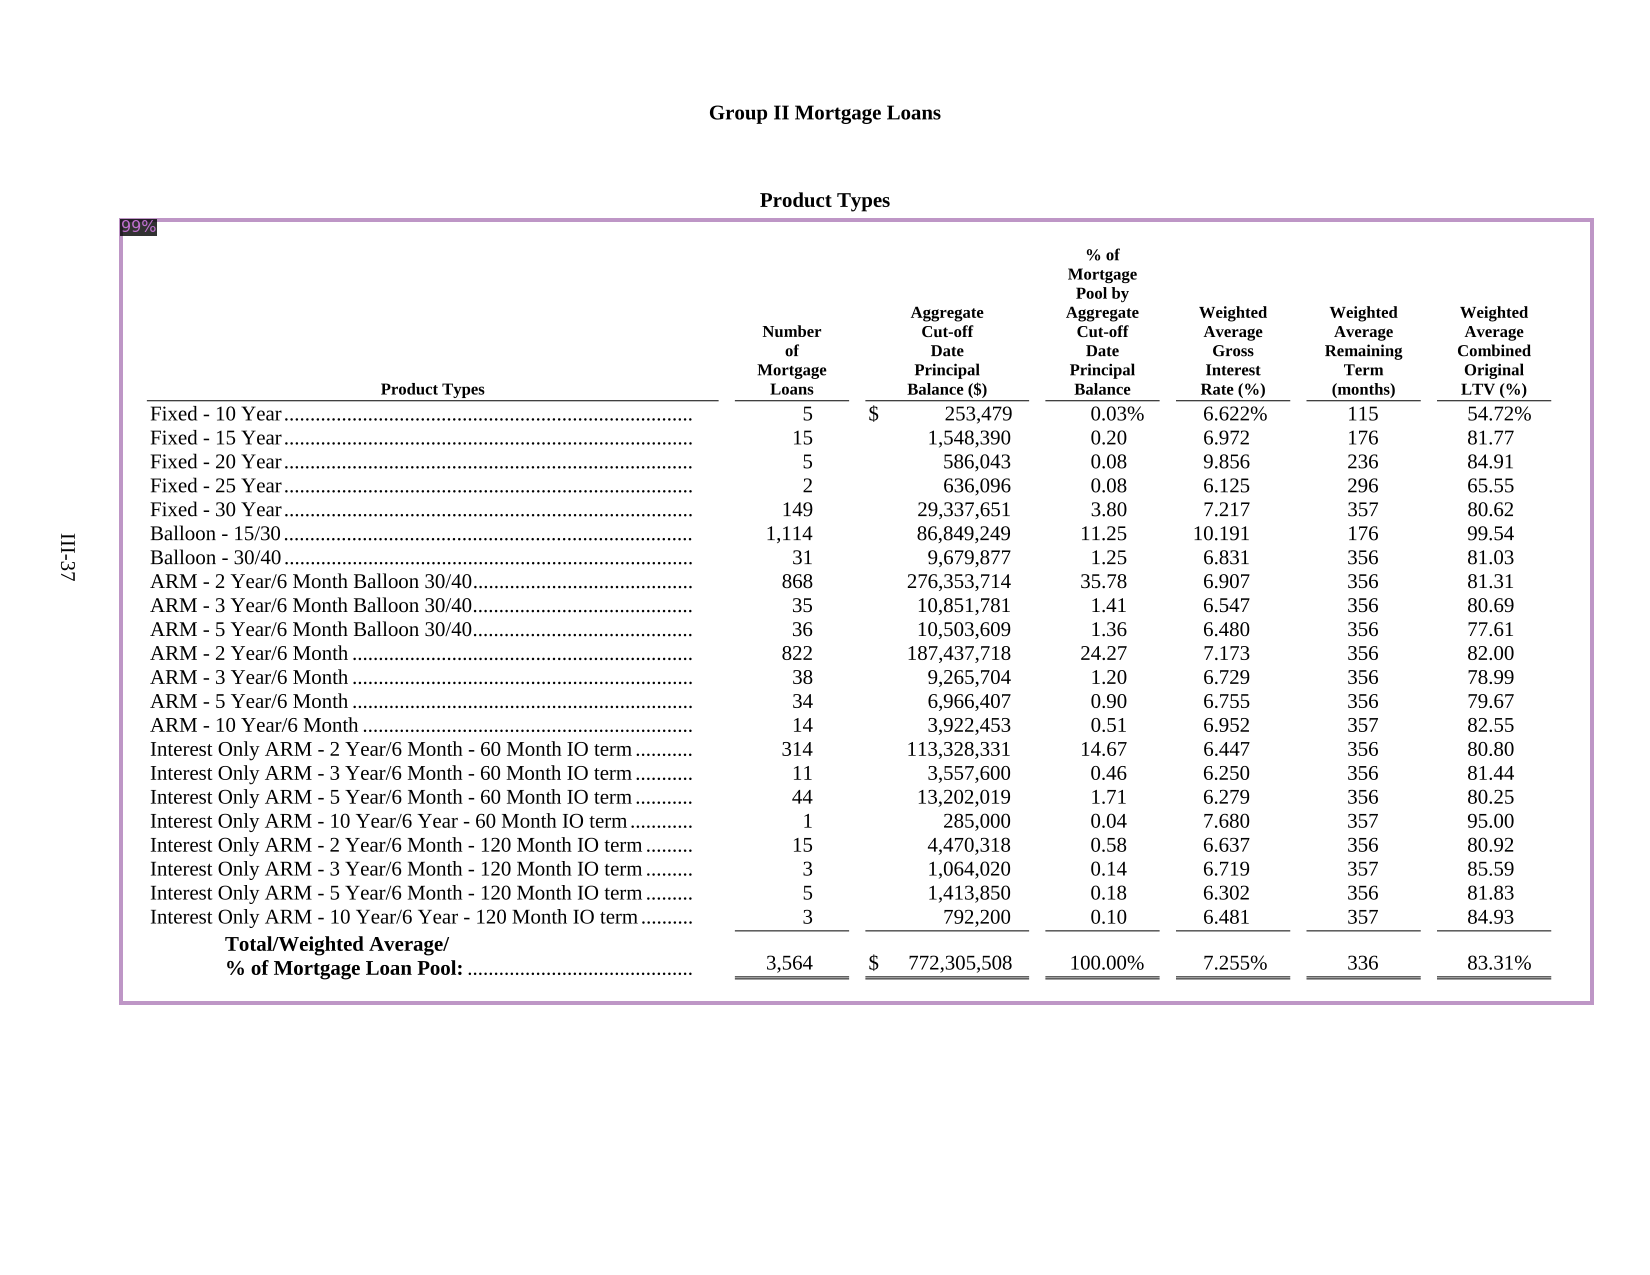

There is no table in this page:  25
There is no table in this page:  72
There is no table in this page:  96
{'160': [[241.48486328125, 441.05621337890625, 3184.355224609375, 2007.2105712890625]]}


In [50]:
pages_with_table = {}


for d in random.sample(listOfJPG, 4):  
# for d in listOfJPG:  
    page = d.split('/')[4].split('_')[0]  
    im = cv2.imread(d)
    outputs = predictor(im)
    table_coordinates = outputs["instances"].pred_boxes.tensor.tolist()

    v = Visualizer(im[:, :, ::-1],
                   metadata=table_val_metadata, 
                   scale=0.5, 
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )


    if not table_coordinates:
      print("There is no table in this page: ", page)
      # print(outputs["instances"].pred_boxes.tensor.tolist())
    else:
      print("Page ",page, " table edge coordinates are: ", table_coordinates)
      pages_with_table[page] = table_coordinates

      # Drawing the page with tables
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      cv2_imshow(v.get_image()[:, :, ::-1])

      for i in range(len(table_coordinates)):
        x0 = int(table_coordinates[i][0])
        y0 = int(table_coordinates[i][1])
        x1 = int(table_coordinates[i][2])
        y1 = int(table_coordinates[i][3])
        crop = im[y0:y1, x0:x1]
        pdf = pytesseract.image_to_pdf_or_hocr(crop, extension='pdf')
        with open('/content/Table_PDF/' + d.split('/')[4][0:-4], 'w+b') as f:
          f.write(pdf)
      


print(pages_with_table)

In [35]:
print(len(pages_with_table))

90


### Loading Camelot Libary to table extraction

In [23]:
pip install camelot-py

     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
     |████████████████████████████████| 5.6MB 18.7MB/s 
     |████████████████████████████████| 13.7MB 239kB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp36-none-any.whl size=61086 sha256=98ad825a740fc3d2de68bf0e1daebfbaa62e6dbddf4d7b5e493774e5a3b6ef08
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


In [0]:
pip install ghostscript

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/gs952w64.exe /usr/local/bin

In [0]:
!chmod 755 /usr/local/bin/gs952w64.exe

In [0]:
import camelot
# tables = camelot.read_pdf('foo.pdf')
# tables

In [28]:
tables = camelot.read_pdf('foo.pdf')

RuntimeError: ignored